###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 2: Book Rating Prediction

**Student IDs:**     1264462 & 1269549

# README

* To run the complete code in Jupyter Notebook, simply click Kernel > Restart & Run All.
    * Note that it might take a while to generate the output - the slowest model takes about < 7 minutes.
    * Alternatively, select the relevant cell, and click 'Run'.
* Code lines commented out with `##` are for printing out information that may be of interest. You may uncomment it to see the output.
* The dataset files (both the original and preprocessed) are assumed to exist in the directory "**./Resources/Datasets/**".
* Here we make use of the IPython built-in magic command (`%run`) to run the helper notebook: `Global.ipynb`. You do not need to open and run it separately.
* This code makes use of a library "mlxtend". To install it, run in the terminal: `pip install mlxtend`.
    * More details about this library can be found here: https://rasbt.github.io/mlxtend/.
* Each model may use a slightly different version of the preprocessed dataset. Running this code generates the "train_df.csv" and "test_df.csv" file. 
    * The other versions were pre-generated, which only requires a small change in a function parameter or some further feature selection.
    * A more detailed description of these datasets can be found in "README.txt" in the "Resources" folder residing in the same directory. 
* This code also generates CSV files ("[model]_pred.csv"), which contain the final predictions made by each model on the test set.

In [43]:
%run Global.ipynb

In [44]:
# Load datasets
train_df = pd.read_csv(DATASET_DIR + "book_rating_train.csv", index_col = False, delimiter = ',', header=0)
test_df = pd.read_csv(DATASET_DIR + "book_rating_test.csv", index_col = False, delimiter = ',', header=0)
entire_df = pd.concat([train_df, test_df])

# 1. Data Preprocessing

Note: Here we show the individual preprocessing steps for the training set for clarity. At the end we pull everything together to preprocess the test set.

## Preprocess String features: Authors and Publisher

In [3]:
CATEGORICAL_FEATURES = ['Authors', 'Publisher']
MISSING_CAT_VAL = ''

In [4]:
train_df = train_df.drop('Language', axis=1)  # this feature has too many missing values

for df in [train_df, entire_df]:
    for feature in CATEGORICAL_FEATURES:
        df[feature] = df[feature].fillna(MISSING_CAT_VAL)  # impute missing values
        df[feature] = df[feature].apply(lambda x: preprocess(x, stop_words_removal=False, lemmatize=False, min_word_len=0))

### One-Hot Encoding

In [5]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=3, sparse=False)
OHE.fit(entire_df[CATEGORICAL_FEATURES])

OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=3,
              sparse=False, sparse_output=False)

In [6]:
def ohe_transform(df, has_labels=False):
    """
    Transforms the dataset by one-hot-encoding, on the categorical features only.
    `has_label` indicates whether the DataFrame contains the class labels.
        If True, these are moved to the last column.
    Returns the transformed DataFrame.
    """
    transformed_mat = OHE.transform(df[CATEGORICAL_FEATURES])
    transformed_cat_df = pd.DataFrame(transformed_mat).set_axis(OHE.get_feature_names_out(), axis=1, inplace=False)
    transformed_df = pd.concat([df.reset_index(drop=True), transformed_cat_df], axis=1)
    transformed_df = transformed_df.drop(CATEGORICAL_FEATURES, axis=1)  # drop the original attributes
    
    if has_labels:
        # move rating_label to the last column
        labels = transformed_df[CLASS_LABEL]
        transformed_df = pd.concat([transformed_df.drop([CLASS_LABEL], axis=1), labels], axis=1)
    
    return transformed_df

In [7]:
ALPHA = 0.05

# Select one-hot-encoded features using chi2
x2 = SelectKBest(chi2, k='all')
x2.fit(ohe_transform(train_df)[OHE.get_feature_names_out()], train_df[CLASS_LABEL])
pvals = pd.DataFrame(x2.pvalues_, index=x2.feature_names_in_, columns=['p-value'])
## print(pvals)

INSIG_OHE_FEATURES = pvals[pvals['p-value'] >= ALPHA].index.tolist()  # insignificant encoded features
sig_ohe_features = pvals[pvals['p-value'] < ALPHA].index.tolist()
print(len(sig_ohe_features), "features are significant.")
## sig_ohe_features

497 features are significant.


In [8]:
train_df = ohe_transform(train_df, has_labels=True)
train_df = train_df.drop(INSIG_OHE_FEATURES, axis=1)

## Discretize 'Numerical' features

In [9]:
# First drop PublishDay and PublishMonth
train_df = train_df.drop(['PublishDay', 'PublishMonth'], axis=1)

In [10]:
from sklearn.preprocessing import KBinsDiscretizer

def discretize(df, feature, discretizer=None, strategy='kmeans', n_bins=5):
    """
    Discretizes the feature in the given DataFrame.
    - discretizer: the discretizer; 
      If None, creates a KBinsDiscretizer for ordinal data, with the specified strategy and number of bins.
    - strategy: the discretization strategy (one of ['kmeans', 'quantile', 'uniform']).
    - n_bins: the number of bins.
    Returns the transformed dataset and discretizer used.
    """
    
    if discretizer is None:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        discretizer.fit(df[[feature]])
        
    transformed_df = df.copy()
    transformed_df[feature] = discretizer.transform(df[[feature]])
    
    return transformed_df, discretizer

In [11]:
# PublishYear
train_df, DISCRETIZER_PY = discretize(train_df, 'PublishYear', strategy='uniform', n_bins=15)

# pagesNumber
train_df, DISCRETIZER_PN = discretize(train_df, 'pagesNumber', strategy='kmeans', n_bins=7)

## Text Pre-processing

In [12]:
TEXT_FEATURES = ['Name', 'Description']

In [13]:
train_df_name, VECTORIZER_NAME = preprocess_text_feature(train_df, 'Name', ngram=2, delimiter='_')  # distinguish from Description features
train_df_desc, VECTORIZER_DESC = preprocess_text_feature(train_df, 'Description', ngram=2)

In [14]:
# Bind them together
train_df = pd.concat([train_df.reset_index(drop=True), train_df_name, train_df_desc], axis=1)
train_df = train_df.drop(TEXT_FEATURES, axis=1)  # drop the original columns

In [15]:
# Move rating_label to the last column
labels = train_df[CLASS_LABEL].astype('category')
train_df = pd.concat([train_df.drop([CLASS_LABEL], axis=1), labels], axis=1) 

## Normalization

In [16]:
from sklearn.preprocessing import MinMaxScaler

train_df_X = train_df.iloc[:,:-1]
train_df_y = train_df.iloc[:,-1]
SCALER = MinMaxScaler()
scaled = SCALER.fit_transform(train_df_X)

In [17]:
scaled_X = pd.DataFrame(scaled, columns=train_df_X.columns)
train_df = pd.concat([scaled_X, train_df_y], axis=1)
train_df

,PublishYear,pagesNumber,Authors_,Authors_aaron mccollough,Authors_abu hamid al ghazali,Authors_agatha christie,Authors_alba de c spedes,Authors_alexander kent,Authors_alexander schmemann,Authors_alexandre dumas,...,book offer,young woman,science fiction,well known,br em,real life,tell story,african american,san francisco,rating_label
0,0.928571,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,0.857143,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.928571,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.928571,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,0.928571,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,0.857143,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
23059,0.928571,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
23060,0.857143,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
23061,0.928571,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [18]:
# Save the preprocessed training set
train_df.to_csv(DATASET_DIR + "train_df.csv", index=False)

## Altogether

In [19]:
def preprocess_test_df(df, name_vectorizer, desc_vectorizer, scaler, max_features = 50):
    """
    Preprocesses the test dataset and returns the preprocessed version as a DataFrame.
    """
    df = df.copy()
    
    # preprocess string features
    df = df.drop(['Language'], axis=1)
    
    for feature in CATEGORICAL_FEATURES:
        df[feature] = df[feature].fillna(MISSING_CAT_VAL)  # imputation
        df[feature] = df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
    df = ohe_transform(df).drop(INSIG_OHE_FEATURES, axis=1)  # one-hot-encoding
    
    # preprocess numerical features
    df = df.drop(['PublishDay', 'PublishMonth'], axis=1)
    df = discretize(df, 'PublishYear', discretizer=DISCRETIZER_PY)[0]
    df = discretize(df, 'pagesNumber', discretizer=DISCRETIZER_PN)[0]
    
    # preprocess text features
    df_name = preprocess_text_feature(df, 'Name', vectorizer=name_vectorizer, delimiter='_', max_features = max_features)[0]
    df_desc = preprocess_text_feature(df, 'Description', vectorizer=desc_vectorizer, max_features = max_features)[0]
    
    # put together and discard the (obsolete) original features
    df = pd.concat([df.reset_index(drop=True), df_name, df_desc], axis=1)
    df = df.drop(['Name', 'Description'], axis=1)
    
    # normalize
    if scaler is None: 
            scaler = MinMaxScaler().fit(df)
    df = pd.DataFrame(scaler.transform(df), columns=df.columns)
        
    return df, scaler

In [22]:
# Apply to the test set
test_df = preprocess_test_df(test_df, VECTORIZER_NAME, VECTORIZER_DESC, SCALER)[0]
test_df.to_csv(DATASET_DIR + "test_df.csv", index=False)

# Create different datasets
train_df_orig = pd.read_csv(DATASET_DIR + "book_rating_train.csv", index_col = False, delimiter = ',', header=0)
X_train_orig = train_df_orig.iloc[:,:-1]
y_train = train_df_orig.iloc[:,-1]

X_train_50 = preprocess_test_df(X_train_orig, None, None, None, max_features=50)[0]
X_train_100 = preprocess_test_df(X_train_orig, None, None, None, max_features=100)[0]
X_train_200 = preprocess_test_df(X_train_orig, None, None, None, max_features=200)[0]
X_train_300, scaler_300 = preprocess_test_df(X_train_orig, None, None, None, max_features=300)

train_df_50 = pd.concat([X_train_50, y_train], axis=1)
train_df_100 = pd.concat([X_train_100, y_train], axis=1)
train_df_200 = pd.concat([X_train_200, y_train], axis=1)
train_df_300 = pd.concat([X_train_300, y_train], axis=1)

train_df_50.to_csv(DATASET_DIR + "train_df_50.csv", index=False)
train_df_100.to_csv(DATASET_DIR + "train_df_100.csv", index=False)
train_df_200.to_csv(DATASET_DIR + "train_df_200.csv", index=False)
train_df_300.to_csv(DATASET_DIR + "train_df_300.csv", index=False)

# create testing dataset for 300 features 
train_300 = pd.read_csv(DATASET_DIR + "book_rating_train.csv", index_col = False, delimiter = ',', header=0)
test_300 = pd.read_csv(DATASET_DIR + "book_rating_test.csv", index_col = False, delimiter = ',', header=0)
_, VECTORIZER_NAME_300 = preprocess_text_feature(train_300, 'Name', ngram=2, delimiter='_', max_features = 300)  # distinguish from Description features
_, VECTORIZER_DESC_300 = preprocess_text_feature(train_300, 'Description', ngram=2, max_features = 300)
test_300 = preprocess_test_df(test_300, VECTORIZER_NAME_300, VECTORIZER_DESC_300, scaler_300, max_features=300)[0]
test_300.to_csv(DATASET_DIR + "test_df_300.csv", index=False)

# 2. Building the models

In [50]:
## train_df = pd.read_csv(DATASET_DIR + "train_df.csv", keep_default_na=False)  # Alternative
# These are the 50-TFIDF-features dataset
X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]

## 1) Linear SVM

In [51]:
from sklearn.svm import LinearSVC

In [52]:
# LSVM's dataset with its own selected features
lsvm_train = pd.read_csv(DATASET_DIR + "LSVM_train.csv", keep_default_na=False)
X_lsvm = lsvm_train.iloc[:,:-1]

lsvm = LinearSVC(random_state=30027, C=5, dual=False)
lsvm.fit(X_lsvm, y_train)

LinearSVC(C=5, dual=False, random_state=30027)

LinearSVC prediction took 2.9592978954315186 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.750000    0.194208      0.308525       0.739480    0.964837   
1       0.718954    0.187394      0.297297       0.739953    0.965453   
2       0.755102    0.189420      0.302865       0.739090    0.971622   
3       0.735714    0.175768      0.283747       0.738028    0.969772   
4       0.804196    0.196246      0.315501       0.740741    0.974707   
5       0.689655    0.170648      0.273598       0.737612    0.964220   
6       0.750000    0.163823      0.268908       0.735198    0.972856   
7       0.755245    0.184300      0.296296       0.740376    0.972856   
8       0.767606    0.185690      0.299040       0.737113    0.970988   
9       0.742647    0.172061      0.279391       0.737612    0.964815   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.837259       0.450000    0.181818      0.258993  0.735154  
1  

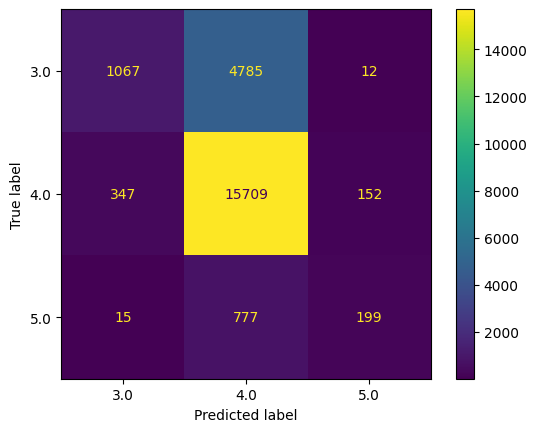

,mean,std
3.0_precision,0.746912,0.029942
3.0_recall,0.181956,0.010811
3.0_f1-score,0.292517,0.015405
4.0_precision,0.738520,0.001718
4.0_recall,0.969213,0.003994
4.0_f1-score,0.838281,0.001923
5.0_precision,0.549870,0.071220
5.0_recall,0.200869,0.041315
5.0_f1-score,0.292592,0.050539
accuracy,0.736027,0.003047


In [53]:
y_pred_lsvm, lsvm_report = cross_val_report(lsvm, X_lsvm, y_train)
lsvm_report

In [54]:
LSVM_FEATURES = X_lsvm.columns  # will be used for test set

## 2) Stacking Naive Bayes

In [79]:
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB

In [80]:
GNB_FEATURES = ['pagesNumber', 'PublishYear']
BNB_FEATURES = read_list(RESOURCE_DIR + "BNB_features.txt")
MNB_FEATURES = read_list(RESOURCE_DIR + "MNB_features.txt")

In [81]:
gnb = make_pipeline(ColumnSelector(GNB_FEATURES),
                      GaussianNB(var_smoothing=0.1))
bnb = make_pipeline(ColumnSelector(BNB_FEATURES),
                      BernoulliNB(alpha=0.1))
mnb = make_pipeline(ColumnSelector(MNB_FEATURES),
                      MultinomialNB(alpha=0.01))

cvsnb = StackingCVClassifier(classifiers=[gnb, bnb, mnb], 
                            meta_classifier=CategoricalNB(alpha=0.01),
                            random_state=30027)

cvsnb.fit(X_train, y_train)

StackingCVClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=['pagesNumber',
                                                                        'PublishYear'])),
                                                  ('gaussiannb',
                                                   GaussianNB(var_smoothing=0.1))]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=['Authors_',
                                                                        'Authors_aaron '
                                                                        'mccollough',
                                                                        'Authors_abu '
                                                                        'hamid '
                                                                        'al '
                                                                        'ghazali',
                                                                        'Authors_agatha '
                                                                        'christie',
                                                                        'Authors_alba '
                                                                        'de c '
                                                                        'spedes',...
                                                                        'year '
                                                                        'old',
                                                                        'year '
                                                                        'ago',
                                                                        'short '
                                                                        'story',
                                                                        'time '
                                                                        'br',
                                                                        'first '
                                                                        'time',
                                                                        'around '
                                                                        'world',
                                                                        'best '
                                                                        'selling',
                                                                        'civil '
                                                                        'war',
                                                                        'book '
                                                                        'br',
                                                                        'united '
                                                                        'state',
                                                                        'full '
                                                                        'color',
                                                                        'th '
                                                                        'century',
                                                                        'br '
                                                                        'new',
                                                                        'available '
                                                                        'purchase',
                                                                        'step '
                                                                        'step',
                                                                        'well '
                          

StackingCVClassifier prediction took 3.1971919536590576 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.738562    0.192504      0.305405       0.738884    0.963603   
1       0.705521    0.195911      0.306667       0.740548    0.966687   
2       0.751592    0.201365      0.317631       0.741631    0.970389   
3       0.713333    0.182594      0.290761       0.738701    0.967921   
4       0.751592    0.201365      0.317631       0.740462    0.969772   
5       0.712418    0.186007      0.294993       0.740898    0.966687   
6       0.696296    0.160410      0.260749       0.735514    0.971006   
7       0.743243    0.187713      0.299728       0.740254    0.972239   
8       0.733766    0.192504      0.304993       0.739274    0.967901   
9       0.699301    0.170358      0.273973       0.737488    0.964198   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.836412       0.425000    0.171717      0.244604  0.7

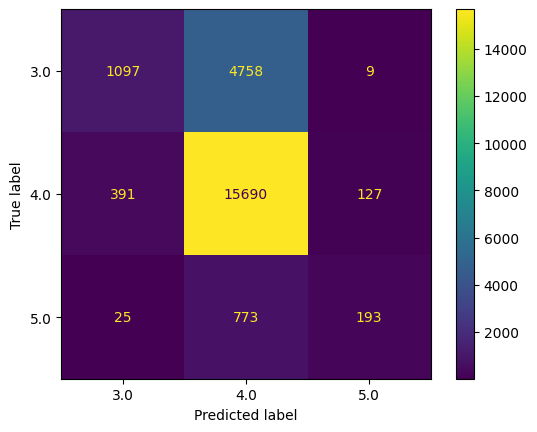

,mean,std
3.0_precision,0.724563,0.021510
3.0_recall,0.187073,0.013155
3.0_f1-score,0.297253,0.018176
4.0_precision,0.739365,0.001823
4.0_recall,0.968040,0.002850
4.0_f1-score,0.838387,0.001675
5.0_precision,0.593464,0.094156
5.0_recall,0.194788,0.034858
5.0_f1-score,0.291778,0.045721
accuracy,0.736244,0.002972


In [82]:
y_pred_cvsnb, cvsnb_report = cross_val_report(cvsnb, X_train, y_train)
cvsnb_report

## 3) Logistic Regression

In [45]:
train_df_logr = pd.read_csv(DATASET_DIR + "train_df_300.csv", keep_default_na=False)  # Alternative
X_train_logr = train_df_logr.iloc[:,:-1]
y_train = train_df_logr.iloc[:,-1]

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
logr = LogisticRegression(solver='sag', max_iter=50, C=5, random_state=30027)  # uses Stochastic Average Gradient descent solver
logr.fit(X_train_logr, y_train)

LogisticRegression(C=5, max_iter=50, random_state=30027, solver='sag')

In [48]:
selector = SelectFromModel(logr, prefit=True).fit(X_train_logr, y_train)
LR_FEATURES = [X_train_logr.columns[i] for i in selector.get_support(indices=True)]

LogisticRegression prediction took 54.98206305503845 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.816794    0.182283      0.298050       0.739252    0.975941   
1       0.733333    0.149915      0.248939       0.733736    0.974090   
2       0.818898    0.177474      0.291725       0.738404    0.982110   
3       0.754386    0.146758      0.245714       0.732192    0.976558   
4       0.803279    0.167235      0.276836       0.735622    0.978408   
5       0.735043    0.146758      0.244666       0.733796    0.977791   
6       0.823529    0.143345      0.244186       0.733763    0.982727   
7       0.777778    0.167235      0.275281       0.738726    0.980259   
8       0.860870    0.168654      0.282051       0.736574    0.982099   
9       0.777778    0.143101      0.241727       0.734136    0.978395   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.841266       0.527778    0.191919      0.281481  0.7403

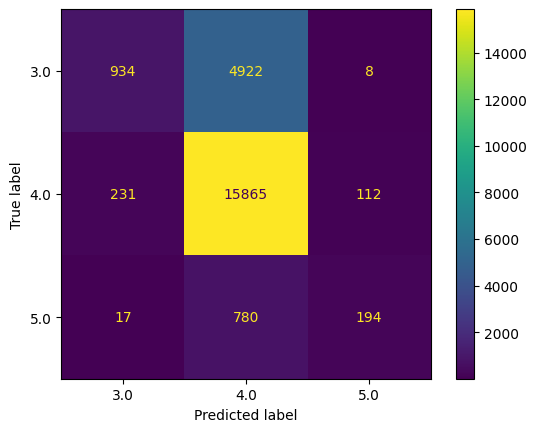

,mean,std
3.0_precision,0.790169,0.041732
3.0_recall,0.159276,0.014876
3.0_f1-score,0.264918,0.022013
4.0_precision,0.735620,0.002489
4.0_recall,0.978838,0.002908
4.0_f1-score,0.839975,0.002179
5.0_precision,0.618496,0.081684
5.0_recall,0.195818,0.035939
5.0_f1-score,0.296513,0.048454
accuracy,0.736808,0.003715


In [49]:
logr.fit(X_train_logr[LR_FEATURES], y_train)
y_pred_logr, logr_report = cross_val_report(logr, X_train_logr[LR_FEATURES], y_train)
logr_report

## 4) StackingClassifier

In [24]:
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingCVClassifier

In [ ]:
# Multinomial NB
mnb = MultinomialNB(alpha = 1)
# Linear SVM
linearSVM = svm.LinearSVC(random_state=30027, C=5, dual=False)
# Logistic Regression
logr = LogisticRegression(solver='sag', max_iter=50)
# Decision tree
dt = DecisionTreeClassifier(max_depth = 200, random_state = 30027)
# 3NN
knn = KNeighborsClassifier(n_neighbors=10)

# Stack
sclf = StackingCVClassifier(classifiers=[mnb, linearSVM, logr, dt], 
                            meta_classifier=CategoricalNB(),
                            cv = 2,
                            random_state=30027)

sclf.fit(X_train, y_train)

In [ ]:
# This is slow - be patient!
y_pred_sclf, sclf_report = cross_val_report(sclf, X_train, y_train)
sclf_report

## 5) Baselines

### 0R

DummyClassifier prediction took 0.3522372245788574 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0            0.0         0.0           0.0       0.702644         1.0   
1            0.0         0.0           0.0       0.702644         1.0   
2            0.0         0.0           0.0       0.702644         1.0   
3            0.0         0.0           0.0       0.702949         1.0   
4            0.0         0.0           0.0       0.702949         1.0   
5            0.0         0.0           0.0       0.702949         1.0   
6            0.0         0.0           0.0       0.702949         1.0   
7            0.0         0.0           0.0       0.702949         1.0   
8            0.0         0.0           0.0       0.702515         1.0   
9            0.0         0.0           0.0       0.702515         1.0   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.825356            0.0         0.0           0.0  0.702644

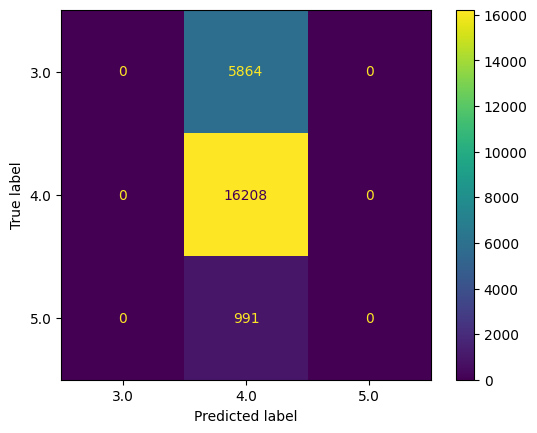

,mean,std
3.0_precision,0.000000,0.000000
3.0_recall,0.000000,0.000000
3.0_f1-score,0.000000,0.000000
4.0_precision,0.702771,0.000194
4.0_recall,1.000000,0.000000
4.0_f1-score,0.825444,0.000134
5.0_precision,0.000000,0.000000
5.0_recall,0.000000,0.000000
5.0_f1-score,0.000000,0.000000
accuracy,0.702771,0.000194


In [86]:
from sklearn.dummy import DummyClassifier

zero_r = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
y_pred_zero_r, zero_r_report = cross_val_report(zero_r, X_train, y_train)
zero_r_report

### 1R

DecisionTreeClassifier prediction took 0.6286900043487549 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0            0.0         0.0           0.0       0.702644         1.0   
1            0.0         0.0           0.0       0.702644         1.0   
2            0.0         0.0           0.0       0.702644         1.0   
3            0.0         0.0           0.0       0.702949         1.0   
4            0.0         0.0           0.0       0.702949         1.0   
5            0.0         0.0           0.0       0.702949         1.0   
6            0.0         0.0           0.0       0.702949         1.0   
7            0.0         0.0           0.0       0.702949         1.0   
8            0.0         0.0           0.0       0.702515         1.0   
9            0.0         0.0           0.0       0.702515         1.0   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.825356            0.0         0.0           0.0  0

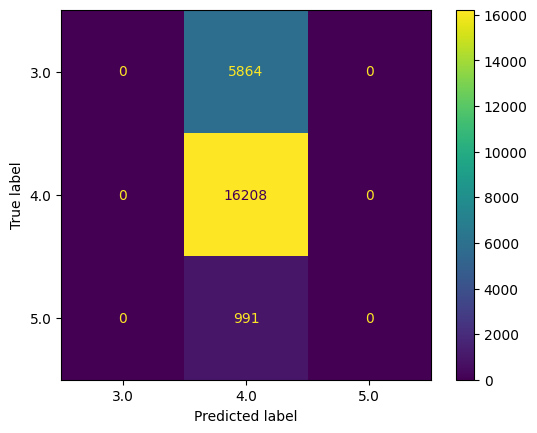

,mean,std
3.0_precision,0.000000,0.000000
3.0_recall,0.000000,0.000000
3.0_f1-score,0.000000,0.000000
4.0_precision,0.702771,0.000194
4.0_recall,1.000000,0.000000
4.0_f1-score,0.825444,0.000134
5.0_precision,0.000000,0.000000
5.0_recall,0.000000,0.000000
5.0_f1-score,0.000000,0.000000
accuracy,0.702771,0.000194


In [87]:
from sklearn.tree import DecisionTreeClassifier

one_r = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)
y_pred_one_r, one_r_report = cross_val_report(one_r, X_train, y_train)
one_r_report

[Text(0.5, 0.75, 'x[1] <= 0.25\ngini = 0.44\nsamples = 23063\nvalue = [5864, 16208, 991]'),
 Text(0.25, 0.25, 'gini = 0.452\nsamples = 17602\nvalue = [4900, 12063, 639]'),
 Text(0.75, 0.25, 'gini = 0.389\nsamples = 5461\nvalue = [964, 4145, 352]')]

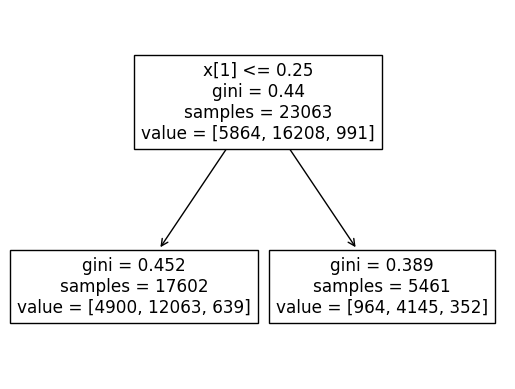

In [88]:
# Look at the Decision Stump
from sklearn import tree
tree.plot_tree(one_r)

# 3. Final predictions on the test set

In [89]:
## X_test = pd.read_csv(DATASET_DIR + "test_df.csv", keep_default_na=False)  # Alternative
X_test = test_df

In [90]:
# Linear SVM
X_test_lsvm = X_test[LSVM_FEATURES]
get_pred_df(lsvm.predict(X_test_lsvm)).to_csv(PREDICTION_DIR+"lsvm_pred.csv", index=False)

In [91]:
# Stacking NB
get_pred_df(cvsnb.predict(X_test)).to_csv(PREDICTION_DIR+"cvsnb_pred.csv", index=False)

In [29]:
# Logistic Regression
X_test_logr = pd.read_csv(DATASET_DIR + "test_df_300.csv", keep_default_na=False)
get_pred_df(logr.predict(X_test_logr[LR_FEATURES])).to_csv(PREDICTION_DIR+"logr_pred.csv", index=False)

In [ ]:
# Stacking Clf
get_pred_df(sclf.predict(X_test_sclf)).to_csv(PREDICTION_DIR+"sclf_pred.csv", index=False)
pd.read_csv("sclf_pred.csv")  # how the results look